# Setup and import data

In [ ]:
import pandas as pd
import numpy as np
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
#Open the workbook
sh = gc.open('data')

#Extract the sheet from the workbook
ws = sh.worksheet("Sheet1")

#Create dataframe
df = pd.DataFrame.from_records(ws.get_all_values())

#Check dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       266 non-null    object
 1   1       266 non-null    object
 2   2       266 non-null    object
 3   3       266 non-null    object
dtypes: object(4)
memory usage: 8.4+ KB


In [ ]:
#Rename columns
df = df.loc[1: , :] #drop the top row (which is column names in the sheet), then rename
df.columns = ["statement","equivocal_word","ambiguous_structure","user_sentiment"]

#Recode binary variables
df.equivocal_word = df.equivocal_word.map(dict(TRUE=True, FALSE=False))
df.ambiguous_structure = df.ambiguous_structure.map(dict(TRUE=True, FALSE=False))

<ipython-input-58-d3b51d6bc619>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.equivocal_word = df.equivocal_word.map(dict(TRUE=True, FALSE=False))
<ipython-input-58-d3b51d6bc619>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ambiguous_structure = df.ambiguous_structure.map(dict(TRUE=True, FALSE=False))


In [ ]:
#Summarize the data
equi = df[df['equivocal_word']==True]
pct_equi = 100 * equi.shape[0]/df.shape[0]

ambi = df[df['ambiguous_structure']==True]
pct_ambi = 100 * ambi.shape[0]/df.shape[0]

both = df[(df['equivocal_word']==True) & (df['ambiguous_structure']==True)]
pct_both = 100 * both.shape[0]/df.shape[0]

print("%.0f statements in our dataset." %(df.shape[0]))
print("%.0f statements with equivocal words, %.1f%% of the dataset." %(equi.shape[0],pct_equi))
print("%.0f statements with ambiguous statements, %.1f%% of the dataset." %(ambi.shape[0],pct_ambi))
print("%.0f statements with both equivocal words and ambiguous statements, %.1f%% of the dataset." %(both.shape[0],pct_both))

265 statements in our dataset.
189 statements with equivocal words, 71.3% of the dataset.
81 statements with ambiguous statements, 30.6% of the dataset.
9 statements with both equivocal words and ambiguous statements, 3.4% of the dataset.


In [ ]:
df['equivocal_word'] = df['equivocal_word'].replace({'True': 0, 'False': 1})

In [ ]:
df

,statement,equivocal_word,ambiguous_structure,user_sentiment
1,Duck!,True,False,Neutral
2,The chicken is ready to eat,False,True,Neutral
3,Shoot!,True,False,Ambiguous
4,He's a good shot,True,False,Positive
5,I'm dead,True,False,Ambiguous
...,...,...,...,...
261,They ate sandwiches with ham and cheese,False,True,Neutral
262,I convinced her children are important,False,True,Neutral
263,She saw the bat flying around the room with he...,False,True,Ambiguous
264,"After the accident, the police officer helped ...",False,True,Ambiguous


In [ ]:
from nltk.corpus import stopwords
import re
import string
import nltk

In [ ]:
#Removing stowords
#This part removes unnecessary data points such as punctuations and words that do not add to the meaning of the text.
nltk.download('stopwords')
stop = stopwords.words('english')

regex = re.compile('[%s]' % re.escape(string.punctuation))

def test_re(s):
    return regex.sub('', s)

df ['content_without_stopwords'] = df['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df ['content_without_puncs'] = df['content_without_stopwords'].apply(lambda x: regex.sub('',x))
del df['statement']
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,equivocal_word,ambiguous_structure,user_sentiment,content_without_stopwords,content_without_puncs
1,True,False,Neutral,Duck!,Duck
2,False,True,Neutral,The chicken ready eat,The chicken ready eat
3,True,False,Ambiguous,Shoot!,Shoot
4,True,False,Positive,He's good shot,Hes good shot
5,True,False,Ambiguous,I'm dead,Im dead
...,...,...,...,...,...
261,False,True,Neutral,They ate sandwiches ham cheese,They ate sandwiches ham cheese
262,False,True,Neutral,I convinced children important,I convinced children important
263,False,True,Ambiguous,She saw bat flying around room friend,She saw bat flying around room friend
264,False,True,Ambiguous,"After accident, police officer helped woman br...",After accident police officer helped woman bro...


In [ ]:
#Remove digits from the sentences and store the clean contents in a new column

noNums = []
for i in range(df.shape[0]):
  noNums.append(''.join([j for j in df['content_without_puncs'].iloc[i] if not j.isdigit()]))

df['content'] = noNums
df = df.drop(columns=['content_without_puncs'])
df


,equivocal_word,ambiguous_structure,user_sentiment,content_without_stopwords,content
1,True,False,Neutral,Duck!,Duck
2,False,True,Neutral,The chicken ready eat,The chicken ready eat
3,True,False,Ambiguous,Shoot!,Shoot
4,True,False,Positive,He's good shot,Hes good shot
5,True,False,Ambiguous,I'm dead,Im dead
...,...,...,...,...,...
261,False,True,Neutral,They ate sandwiches ham cheese,They ate sandwiches ham cheese
262,False,True,Neutral,I convinced children important,I convinced children important
263,False,True,Ambiguous,She saw bat flying around room friend,She saw bat flying around room friend
264,False,True,Ambiguous,"After accident, police officer helped woman br...",After accident police officer helped woman bro...


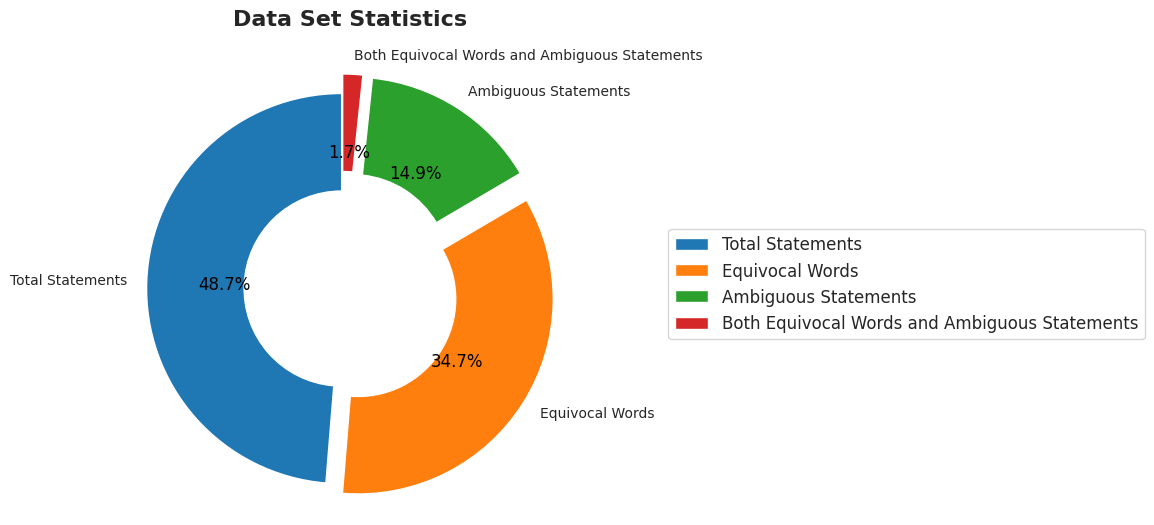

In [ ]:
import matplotlib.pyplot as plt

# Calculate statistics
equi = df[df['equivocal_word']==True]
pct_equi = 100 * equi.shape[0]/df.shape[0]

ambi = df[df['ambiguous_structure']==True]
pct_ambi = 100 * ambi.shape[0]/df.shape[0]

both = df[(df['equivocal_word']==True) & (df['ambiguous_structure']==True)]
pct_both = 100 * both.shape[0]/df.shape[0]

# Create visualization
labels = ['Total Statements', 'Equivocal Words', 'Ambiguous Statements', 'Both Equivocal Words and Ambiguous Statements']
sizes = [df.shape[0], equi.shape[0], ambi.shape[0], both.shape[0]]
explode = (0, 0.1, 0.1, 0.1)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig, ax = plt.subplots(figsize=(8, 6))

# Create pie chart
wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
       wedgeprops=dict(width=0.5, edgecolor='w'))

# Add percentage values to the chart
for i, autotext in enumerate(autotexts):
    if i == 0:
        autotext.set_color('black')
    else:
        autotext.set_color('black')
    autotext.set_fontsize(12)

# Set chart title and legend
ax.set_title('Data Set Statistics', fontsize=16, fontweight='bold', pad=20)
ax.legend(wedges, labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)

# Set equal aspect ratio and remove spines
ax.axis('equal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()

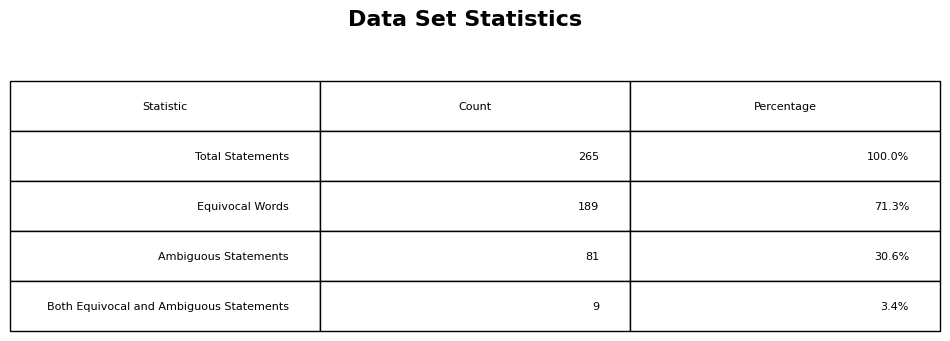

In [ ]:
# Create table of data set statistics
fig, ax = plt.subplots(figsize=(8, 3))

column_labels = ['Statistic', 'Count', 'Percentage']
cell_text = [['Total Statements', '{:,}'.format(df.shape[0]), '100.0%'],
             ['Equivocal Words', '{:,}'.format(equi.shape[0]), '{:.1f}%'.format(pct_equi)],
             ['Ambiguous Statements', '{:,}'.format(ambi.shape[0]), '{:.1f}%'.format(pct_ambi)],
             ['Both Equivocal and Ambiguous Statements', '{:,}'.format(both.shape[0]), '{:.1f}%'.format(pct_both)]]

ax.axis('off')

table = ax.table(cellText=cell_text, colLabels=column_labels, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.5, 3)

# Set chart title
plt.suptitle('Data Set Statistics', fontsize=16, fontweight='bold', y=1.15)

plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfIdfVectorizer=TfidfVectorizer(use_idf=True, sublinear_tf=True)
tfIdf = tfIdfVectorizer.fit_transform(df.content.tolist())

#TTF-IDF is a way to measure how important a word is in a document by multiplying the number of times it appears
# in the document by a value that takes into account how often it appears in other documents. This helps to identify
# words that are unique to a specific document and can be used as a "signature word". The result is a matrix where each
# row represents a document and each column represents a word, with the values representing the importance of each word
#in each document(row). Words with high TF-IDF values are considered important in their respective documents and less important
#in others. This process helps to identify the most relevant words in the documents, which can be used as features in machine learning algorithms.

In [ ]:
print(tfIdf)

  (0, 208)	1.0
  (1, 209)	0.5099874829124608
  (1, 519)	0.5328662690052103
  (1, 115)	0.6039342697671644
  (1, 652)	0.3020425540050298
  (2, 582)	1.0
  (3, 583)	0.5942340694252567
  (3, 278)	0.5687204369170756
  (3, 311)	0.5687204369170756
  (4, 162)	0.7498482714780341
  (4, 329)	0.6616098319715362
  (5, 282)	0.6071115736615706
  (5, 373)	0.6071115736615706
  (5, 209)	0.5126705318743634
  (6, 42)	0.5838486554275834
  (6, 560)	0.8118625176440917
  (7, 708)	0.4818717031116578
  (7, 271)	0.5174936344925126
  (7, 358)	0.5174936344925126
  (7, 67)	0.4818717031116578
  (8, 227)	0.6071115736615706
  (8, 316)	0.6071115736615706
  (8, 47)	0.5126705318743634
  (9, 489)	0.542462058526455
  (9, 46)	0.5724891020769869
  :	:
  (260, 656)	0.35289628911637794
  (261, 146)	0.62883973456689
  (261, 116)	0.5855532390793385
  (261, 330)	0.5115544862803357
  (262, 546)	0.4379991011426662
  (262, 262)	0.40784921545164543
  (262, 250)	0.40784921545164543
  (262, 578)	0.28817339596352654
  (262, 28)	0.4078492

In [ ]:
df2 = pd.DataFrame(tfIdf[2].T.todense(), index=tfIdfVectorizer.get_feature_names_out(), columns=["TF-IDF"]) #for second entry only(just to check if working)
df2


,TF-IDF
able,0.0
accident,0.0
across,0.0
activities,0.0
actually,0.0
...,...
wrote,0.0
yard,0.0
yesterday,0.0
york,0.0


In [ ]:
dfx = pd.DataFrame(tfIdf.toarray(), columns=tfIdfVectorizer.get_feature_names_out())
dfx
#Converiting it to a dataframe so that it is more readable. All the words scored by TfidfVectorizer are represented
#in columns (total 741) and their respective importance score accross 265 rows in our original dataset.

,able,accident,across,activities,actually,add,added,address,after,ahead,...,workers,working,worn,would,write,wrote,yard,yesterday,york,you
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263,0.0,0.379243,0.0,0.0,0.0,0.0,0.0,0.0,0.30851,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def display_scores(vectorizer, tfidf_result):
    scores = zip(vectorizer.get_feature_names_out(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    i=0
    for item in sorted_scores:
        print ("{0:50} Score: {1}".format(item[0], item[1]))
        i = i+1
        if (i > 25):
          break

This is a function that helps to identify the most significant words or phrases in a text document. It uses a mathematical process called "term frequency-inverse document frequency" to determine how important each word or phrase is in the document. The function then sorts the results and displays the top 25 words or phrases along with their scores, which indicates how relevant and unique they are compared to other documents. This can be useful for understanding the main topics of the document and summarizing its content.

In [ ]:
#top 25 words
display_scores(tfIdfVectorizer, tfIdf)

the                                                Score: 9.193909723270046
bank                                               Score: 5.554138721156022
she                                                Score: 5.394052682422982
new                                                Score: 4.3543501037769206
saw                                                Score: 4.304310222214478
he                                                 Score: 4.087109289927062
they                                               Score: 3.5153241902305945
every                                              Score: 3.3973830777394185
man                                                Score: 3.3014257816251447
get                                                Score: 3.2066512743985367
date                                               Score: 3.101417320293982
dog                                                Score: 2.8912627026777367
duck                                               Score: 2.8556080025794115
make 

In [ ]:
df

,equivocal_word,ambiguous_structure,user_sentiment,content_without_stopwords,content
1,True,False,Neutral,Duck!,Duck
2,False,True,Neutral,The chicken ready eat,The chicken ready eat
3,True,False,Ambiguous,Shoot!,Shoot
4,True,False,Positive,He's good shot,Hes good shot
5,True,False,Ambiguous,I'm dead,Im dead
...,...,...,...,...,...
261,False,True,Neutral,They ate sandwiches ham cheese,They ate sandwiches ham cheese
262,False,True,Neutral,I convinced children important,I convinced children important
263,False,True,Ambiguous,She saw bat flying around room friend,She saw bat flying around room friend
264,False,True,Ambiguous,"After accident, police officer helped woman br...",After accident police officer helped woman bro...


In [ ]:
from sklearn.model_selection import train_test_split

X=tfIdf.toarray()
y = np.array(df.equivocal_word.tolist())
#Spltting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(212, 741)
(212,)
(53, 741)
(53,)


This splits a dataset into two parts for training and testing a machine learning model (for testing how well the model performs).

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  0   1]
 [ 62 150]]


In [ ]:
#Test Data
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[ 0  1]
 [14 39]]


In [ ]:
#Random oversampling on training data
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='not majority')
X_over, y_over = oversample.fit_resample(X_train, y_train)

#This code is used to deal with a common problem in machine learning called imbalanced data. This problem happens when we
#have significantly more examples of one class than another in our dataset. For example, if we are trying to predict whether
#a customer will buy a product or not, and we have many more examples of customers who didn't buy than customers who did buy.
#To address this issue, the code uses a technique called random oversampling, which creates new examples of the minority class
# (the class with fewer examples) by duplicating existing examples until the number of examples in the minority class is similar
#to the majority class. This increases the number of examples for the minority class and makes the dataset more balanced.

In [ ]:
print(X_over.shape)
print(y_over.shape)

(300, 741)
(300,)


In [ ]:
unique_elements, counts_elements = np.unique(y_over, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

#The purpose of this is to analyze the distribution of different categories or labels in a dataset.
#In our case, we want to know have many equivocal words with label 0 (True) and how many equivocal
#words with label 1 (False) are in our train dataset.

[[  0   1]
 [150 150]]


In [ ]:
def getStatsFromModel(model):
  print(classification_report(y_test, y_pred))
  disp = plot_precision_recall_curve(model, X_test, y_test)
  disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}')

  logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='(area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
#from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

So, we are using two models (Random forest classifier and Gaussian Naive Bayes) and will compare their performance in predicting accuracy of scored words by tfIdfVectorizer. (For this, my targetted variable is equivocal_words, but it can be used for other varibales as well).

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)

Score: 0.7358490566037735


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


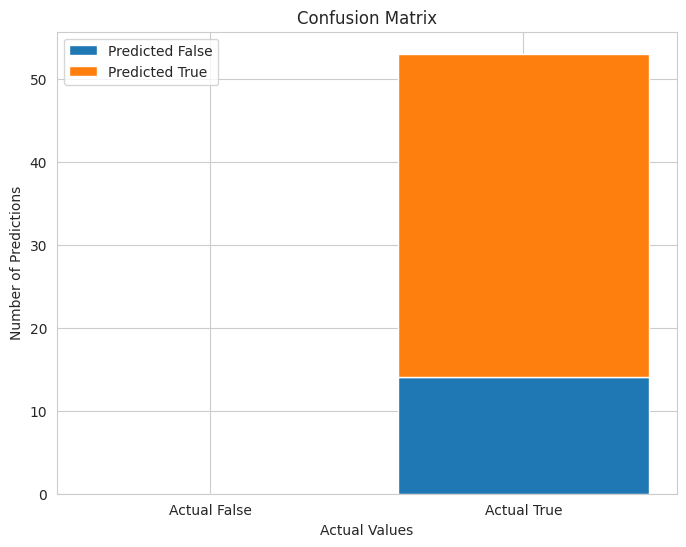

Classification Report:

False:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 14
True:
  Precision: 0.74
  Recall: 1.00
  F1-score: 0.85
  Support: 39
Accuracy: 0.74
Macro avg:
  Precision: 0.37
  Recall: 0.50
  F1-score: 0.42
  Support: 53
Weighted avg:
  Precision: 0.54
  Recall: 0.74
  F1-score: 0.62
  Support: 53


In [ ]:
#Random forest classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Train a random forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Make predictions on test set and evaluate performance
y_pred = rfc.predict(X_test)
print("Score:", rfc.score(X_test, y_test))

# Get confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, output_dict=True)

# Plot the confusion matrix as a bar chart
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(["Actual False", "Actual True"], cm[0], label="Predicted False")
ax.bar(["Actual False", "Actual True"], cm[1], bottom=cm[0], label="Predicted True")
ax.set_xlabel("Actual Values")
ax.set_ylabel("Number of Predictions")
ax.set_title("Confusion Matrix")
ax.legend()
plt.show()

# Print the classification report
print("Classification Report:\n")
for label, metrics in cr.items():
    if label != "accuracy":
        print(f"{label.capitalize()}:\n  Precision: {metrics['precision']:.2f}\n  Recall: {metrics['recall']:.2f}\n  F1-score: {metrics['f1-score']:.2f}\n  Support: {metrics['support']}")
    else:
        print(f"Accuracy: {metrics:.2f}")

The precision and recall values are important measures of a classifier's performance. In this case, the precision value for class 0 is 0, which means that none of the predicted positive cases were actually positive. The recall value for class 0 is also 0, indicating that none of the actual positive cases were correctly identified as positive by the classifier. This shows that the classifier is not good at identifying positive cases for class 0.

On the other hand, the precision and recall values for class 1 are relatively high, indicating that the classifier is performing well at identifying positive cases for this class.

The bar chart provides a visual representation of the precision and recall values for both classes, showing that the classifier is performing poorly for class 0 and relatively well for class 1. The conclusion that can be drawn from this is that the classifier may need to be improved to better identify positive cases for class 0.

Score: 0.7169811320754716
Confusion Matrix:
 [[10  4]
 [11 28]]
Classification Report:
               precision    recall  f1-score   support

       False       0.48      0.71      0.57        14
        True       0.88      0.72      0.79        39

    accuracy                           0.72        53
   macro avg       0.68      0.72      0.68        53
weighted avg       0.77      0.72      0.73        53



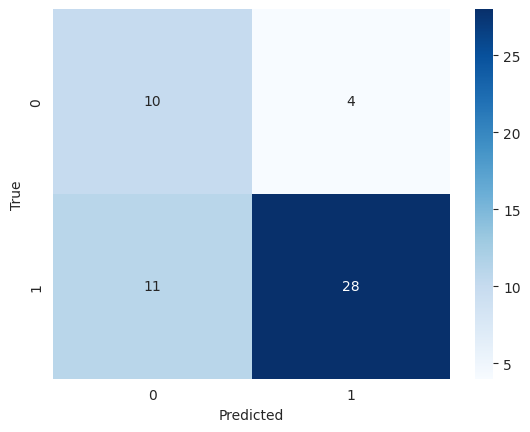

In [ ]:
#Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# fit a Gaussian Naive Bayes model on the imbalanced data
gnb = GaussianNB()
gnbmodel = gnb.fit(X_over, y_over)

# make predictions on test set and evaluate performance
y_pred = gnbmodel.predict(X_test)
print("Score:", gnbmodel.score(X_test, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The result indicates the performance of the Gaussian Naive Bayes model on the test set.
The accuracy of the model is 0.716 or 71.6%. This means that the model correctly classified 71.6% of the instances in the test set.
The confusion matrix shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) of the model. It can be seen that the model correctly classified 10 negative instances and 28 positive instances, but misclassified 4 negative instances as positive and 11 positive instances as negative.
The classification report provides the precision, recall, and F1-score for both classes. Precision measures the proportion of true positives among the instances classified as positive, recall measures the proportion of true positives identified by the model, and F1-score is the harmonic mean of precision and recall.
Based on the confusion matrix and classification report, it can be concluded that the model is better at predicting the positive class (True) than the negative class (False). The precision and recall values for the positive class are higher than the negative class. However, the overall performance of the model can be improved by reducing the number of misclassified instances.

### Gather Pattern sentiment and subjectivity scores

In [ ]:
from textblob import TextBlob

In [ ]:
#Run sentiment analysis
for rowIndex, row in df.iterrows():
  for columnIndex, value in row.items():
    if type(value) == str:
      polarity = TextBlob(value).sentiment.polarity
      subjectivity = TextBlob(value).sentiment.subjectivity
      df.loc[rowIndex, ["textblob_polarity"]] = polarity
      df.loc[rowIndex, ["textblob_subjectivity"]] = subjectivity

### Gather TextBlob sentiment and subjectivity scores

In [ ]:
!pip install pattern &> /dev/null

In [ ]:
import nltk
from pattern.en import sentiment

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
#Create empty columns
df["pattern_polarity"] = np.nan
df["pattern_subjectivity"] = np.nan

#Run sentiment analysis
for rowIndex,row in df.iterrows():
  for columnIndex,value in row.items():
    if columnIndex == "content":
      scores = sentiment(value)
      polarity = scores[0]
      subjectivity = scores[1]
      df.loc[rowIndex, "pattern_polarity"] = polarity
      df.loc[rowIndex, "pattern_subjectivity"] = subjectivity

In [ ]:
# Create statistics table
stats_table = df[["pattern_polarity", "pattern_subjectivity", "textblob_polarity", "textblob_subjectivity"]].describe()

# Print statistics table
print(stats_table)

       pattern_polarity  pattern_subjectivity  textblob_polarity  \
count         265.00000            265.000000          265.00000   
mean            0.03309              0.224756            0.03309   
std             0.24404              0.318759            0.24404   
min            -0.80000              0.000000           -0.80000   
25%             0.00000              0.000000            0.00000   
50%             0.00000              0.000000            0.00000   
75%             0.00000              0.433333            0.00000   
max             1.00000              1.000000            1.00000   

       textblob_subjectivity  
count             265.000000  
mean                0.224756  
std                 0.318759  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.433333  
max                 1.000000  


In [ ]:
df

,equivocal_word,ambiguous_structure,user_sentiment,content_without_stopwords,content,textblob_polarity,textblob_subjectivity,pattern_polarity,pattern_subjectivity
1,True,False,Neutral,Duck!,Duck,0.0,0.000,0.0,0.000
2,False,True,Neutral,The chicken ready eat,The chicken ready eat,-0.2,0.725,-0.2,0.725
3,True,False,Ambiguous,Shoot!,Shoot,0.0,0.000,0.0,0.000
4,True,False,Positive,He's good shot,Hes good shot,0.7,0.600,0.7,0.600
5,True,False,Ambiguous,I'm dead,Im dead,-0.2,0.400,-0.2,0.400
...,...,...,...,...,...,...,...,...,...
261,False,True,Neutral,They ate sandwiches ham cheese,They ate sandwiches ham cheese,0.0,0.000,0.0,0.000
262,False,True,Neutral,I convinced children important,I convinced children important,0.4,1.000,0.4,1.000
263,False,True,Ambiguous,She saw bat flying around room friend,She saw bat flying around room friend,0.0,0.000,0.0,0.000
264,False,True,Ambiguous,"After accident, police officer helped woman br...",After accident police officer helped woman bro...,-0.4,0.400,-0.4,0.400


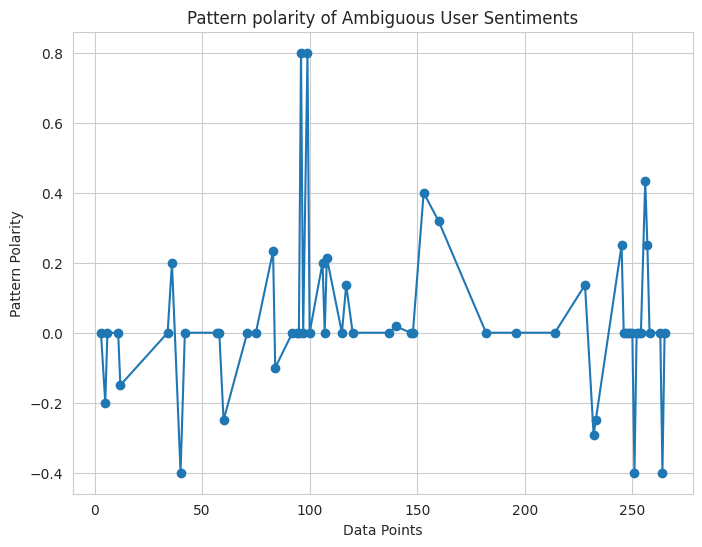

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data
Ambiguous_sentiments = df[(df['user_sentiment'] == 'Ambiguous')]

# Set style
sns.set_style("whitegrid")

# Create line plot
plt.figure(figsize=(8, 6))
plt.plot(Ambiguous_sentiments['pattern_polarity'], marker='o')

# Add title and labels
plt.title('Pattern polarity of Ambiguous User Sentiments')
plt.xlabel('Data Points')
plt.ylabel('Pattern Polarity')

# Show plot
plt.show()

In [ ]:
Ambiguous_sentiments = Ambiguous_sentiments[['content', 'user_sentiment', 'pattern_polarity']]
Ambiguous_sentiments.head(10)

,content,user_sentiment,pattern_polarity
3,Shoot,Ambiguous,0.00
5,Im dead,Ambiguous,-0.20
6,lets eat grandma,Ambiguous,0.00
11,made bow left,Ambiguous,0.00
12,bass pumping,Ambiguous,-0.15
34,likes lie mornings,Ambiguous,0.00
36,The dog ready eat,Ambiguous,0.20
40,Everyone game saw duck,Ambiguous,-0.40
42,Cowards run family,Ambiguous,0.00
57,Every time get boat end rowing,Ambiguous,0.00


The plot shows the  pattern polarity for the user_sentiment group that was classified as "Ambiguous".

Sentiment polarity is a measure of how positive or negative a sentence is, while sentiment subjectivity is a measure of how opinionated or factual a sentence is.

The plot reveals that the majority of sentences in the "Ambiguous" group have a neutral sentiment polarity, meaning that they are neither strongly positive nor negative. Additionally, the plot shows a wide range of sentiment subjectivity values, indicating that the "Ambiguous" group contains sentences with varying degrees of subjectivity.

Overall, the plot provides an insight into the nature of the "Ambiguous" group, showing that it contains mostly neutral sentences with varying degrees of subjectivity.

In [ ]:
df[(df['user_sentiment'] == 'positive') & ((df['pattern_polarity'] <= 0) | (df['textblob_polarity'] <= 0))]

,equivocal_word,ambiguous_structure,user_sentiment,content_without_stopwords,content,textblob_polarity,textblob_subjectivity,pattern_polarity,pattern_subjectivity


In [ ]:
# Count number of results where user_sentiment is positive but polarity or subjectivity score shows otherwise
count = ((df['user_sentiment'] == 'Positive') & ((df['pattern_polarity'] <= 0) | (df['textblob_polarity'] <= 0))).sum()
count
# Print the count
print("Number of results where user_sentiment is positive but polarity score shows otherwise:", count)

#make a table of the variables identified incorrectly

Number of results where user_sentiment is positive but polarity score shows otherwise: 8


In [ ]:
negative_sentiments = df[(df['user_sentiment'] == 'Positive') & ((df['pattern_polarity'] < 0.0) | (df['textblob_polarity'] < 0))]
negative_sentiments

,equivocal_word,ambiguous_structure,user_sentiment,content_without_stopwords,content,textblob_polarity,textblob_subjectivity,pattern_polarity,pattern_subjectivity
10,True,False,Positive,pass bass please,pass bass please,-0.15,0.5,-0.15,0.5


In [ ]:
subset_negative = negative_sentiments[['content', 'user_sentiment', 'pattern_polarity']]
subset_negative

,content,user_sentiment,pattern_polarity
10,pass bass please,Positive,-0.15


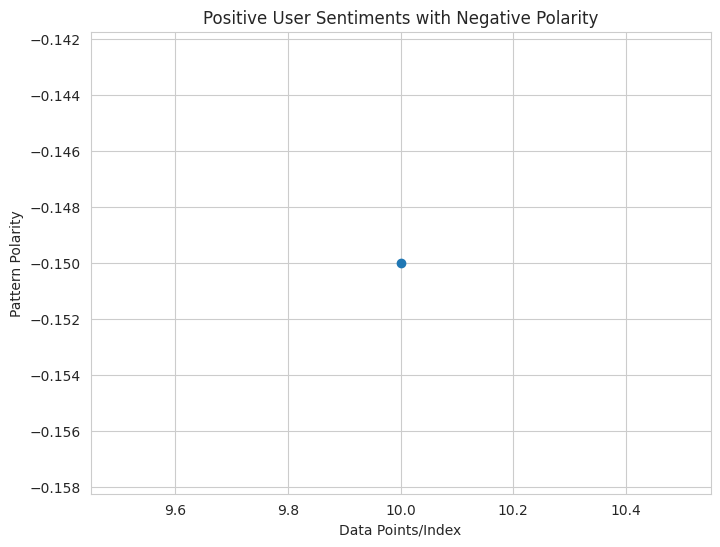

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data
negative_sentiments = df[(df['user_sentiment'] == 'Positive') & (df['pattern_polarity'] < 0)]

# Set style
sns.set_style("whitegrid")

# Create line plot
plt.figure(figsize=(8, 6))
plt.plot(negative_sentiments['pattern_polarity'], marker='o')

# Add title and labels
plt.title('Positive User Sentiments with Negative Polarity')
plt.xlabel('Data Points/Index')
plt.ylabel('Pattern Polarity')

# Show plot
plt.show()

One data point with negative or neutral polarity but actual positive user_sentiment is lower than -0.14. this indicates that the model was not able to correctly perform sentiment analysis on this data point. (same with textblob_polarity, but since the values were similar to pattern polarity, I did not include them in the plot.

In [ ]:
wrong_negative = df[(df['user_sentiment'] == 'Negative') & ((df['pattern_polarity'] > 0))]
num_wrong_negative = len(wrong_negative)
print("Number of negative sentiments with positive polarity or high subjectivity:", num_wrong_negative)

Number of negative sentiments with positive polarity or high subjectivity: 4


In [ ]:
wrong_negative


,equivocal_word,ambiguous_structure,user_sentiment,content_without_stopwords,content,textblob_polarity,textblob_subjectivity,pattern_polarity,pattern_subjectivity
110,True,False,Negative,"He owns lot plants, pay much attention",He owns lot plants pay much attention,0.200000,0.200000,0.200000,0.200000
122,True,False,Negative,"No matter many drills complete, still enough",No matter many drills complete still enough,0.200000,0.466667,0.200000,0.466667
138,True,False,Negative,I think drill working well new recruits,I think drill working well new recruits,0.136364,0.454545,0.136364,0.454545
190,True,False,Negative,It hot eat,It hot eat,0.250000,0.850000,0.250000,0.850000


In [ ]:
subset_positive = wrong_negative[['content', 'user_sentiment', 'pattern_polarity']]
subset_positive

,content,user_sentiment,pattern_polarity
110,He owns lot plants pay much attention,Negative,0.200000
122,No matter many drills complete still enough,Negative,0.200000
138,I think drill working well new recruits,Negative,0.136364
190,It hot eat,Negative,0.250000


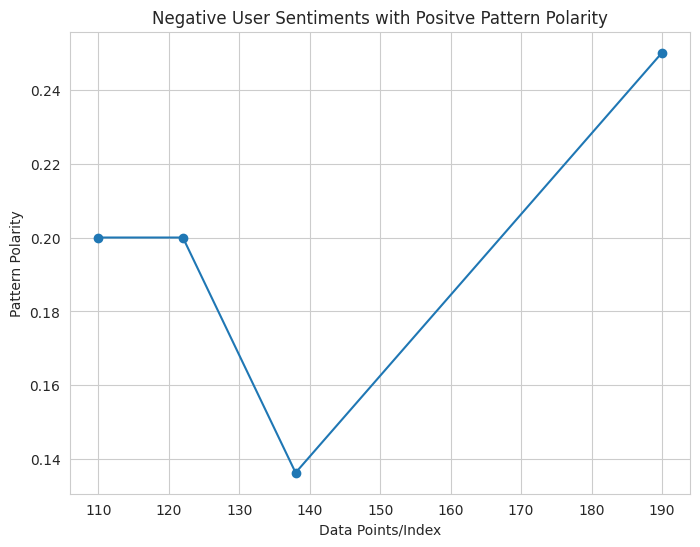

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



# Set style
sns.set_style("whitegrid")

# Create line plot
plt.figure(figsize=(8, 6))
plt.plot(subset_positive['pattern_polarity'], marker='o')

# Add title and labels
plt.title('Negative User Sentiments with Positve Pattern Polarity')
plt.xlabel('Data Points/Index')
plt.ylabel('Pattern Polarity')

# Show plot
plt.show()

These are statements with negative sentiments but positive pattern polarity or textblob polarity. However, they are slightly greater than zero, which means they are not necessarily strongly positive. Still, They are close to 0, and 0 score of pattern polarity or textblob polarity means the staments' sentiments are either slightly positive or neutral.

In [ ]:
#Negative user sentiments that were predicted with neutral polarity.

neutral_sentiment = df[(df['user_sentiment'] == 'Negative') & ((df['pattern_polarity'] == 0))]
num_neutral_negative = len(neutral_sentiment)
print("Number of negative sentiments with neutral polarity:", num_neutral_negative)


Number of negative sentiments with neutral polarity: 25


In [ ]:
neutral_sentiment

,equivocal_word,ambiguous_structure,user_sentiment,content_without_stopwords,content,textblob_polarity,textblob_subjectivity,pattern_polarity,pattern_subjectivity
8,True,False,Negative,board keeps getting way,board keeps getting way,0.0,0.0,0.0,0.0
9,True,False,Negative,bat hit face,bat hit face,0.0,0.0,0.0,0.0
16,True,False,Negative,I broke nail,I broke nail,0.0,0.0,0.0,0.0
18,False,False,Negative,crown's dented,crowns dented,0.0,0.0,0.0,0.0
23,True,False,Negative,mission broke seal,mission broke seal,0.0,0.0,0.0,0.0
28,True,False,Negative,I like molds,I like molds,0.0,0.0,0.0,0.0
32,False,False,Negative,bugs trunk,bugs trunk,0.0,0.0,0.0,0.0
35,False,False,Negative,rolls work way wanted.,rolls work way wanted,0.0,0.0,0.0,0.0
38,False,True,Negative,The burglar robbed woman knife.,The burglar robbed woman knife,0.0,0.0,0.0,0.0
46,True,False,Negative,My mouse died,My mouse died,0.0,0.0,0.0,0.0


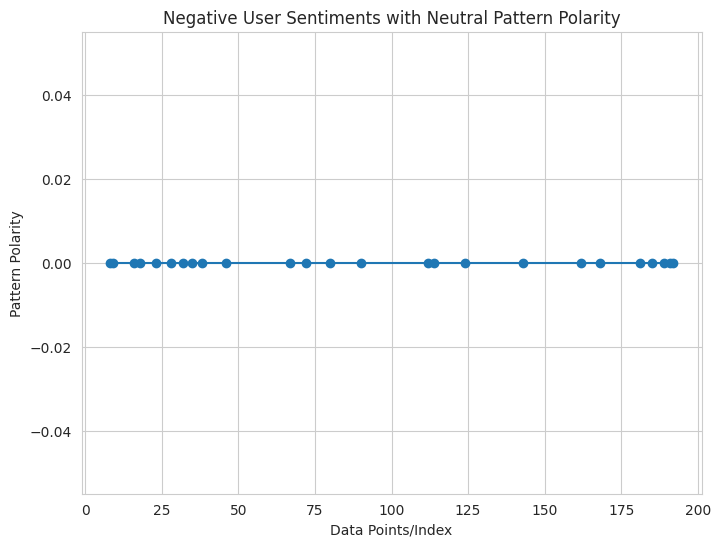

In [ ]:
# Set style
sns.set_style("whitegrid")

# Create line plot
plt.figure(figsize=(8, 6))
plt.plot(neutral_sentiment['pattern_polarity'], marker='o')

# Add title and labels
plt.title('Negative User Sentiments with Neutral Pattern Polarity')
plt.xlabel('Data Points/Index')
plt.ylabel('Pattern Polarity')

# Show plot
plt.show()

In [ ]:
neutral_sentiment = neutral_sentiment[['content', 'user_sentiment', 'pattern_polarity']]
neutral_sentiment.head(10)

,content,user_sentiment,pattern_polarity
8,board keeps getting way,Negative,0.0
9,bat hit face,Negative,0.0
16,I broke nail,Negative,0.0
18,crowns dented,Negative,0.0
23,mission broke seal,Negative,0.0
28,I like molds,Negative,0.0
32,bugs trunk,Negative,0.0
35,rolls work way wanted,Negative,0.0
38,The burglar robbed woman knife,Negative,0.0
46,My mouse died,Negative,0.0


These data points had negative user sentiment, but were predicted neutral by the model.

In [ ]:
# Positive user sentiment with neutral polarity
neutral_positive_sentiment = df[(df['user_sentiment'] == 'Positive') & ((df['pattern_polarity'] == 0))]
num_neutral_negative = len(neutral_positive_sentiment)
print("Number of positive sentiments with neutral polarity:", num_neutral_negative)

Number of positive sentiments with neutral polarity: 7


In [ ]:
neutral_positive_sentiment = neutral_positive_sentiment[['content', 'user_sentiment', 'pattern_polarity']]
neutral_positive_sentiment.head(10)

,content,user_sentiment,pattern_polarity
20,big fan,Positive,0.0
26,hes got four diamonds,Positive,0.0
53,After digging around found steel inside,Positive,0.0
73,At recess decided skip,Positive,0.0
163,Sarah knew well test Bob,Positive,0.0
171,We’ll look table work answer,Positive,0.0
208,Suda faithful dependable clerk,Positive,0.0


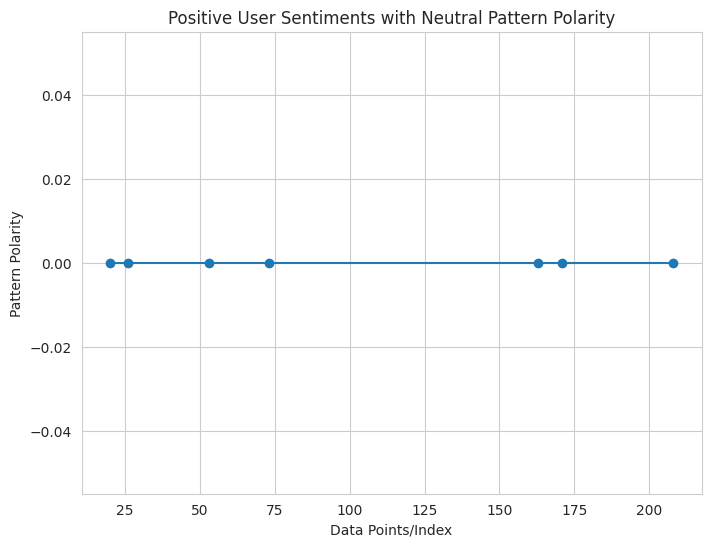

In [ ]:
# Set style
sns.set_style("whitegrid")

# Create line plot
plt.figure(figsize=(8, 6))
plt.plot(neutral_positive_sentiment['pattern_polarity'], marker='o')

# Add title and labels
plt.title('Positive User Sentiments with Neutral Pattern Polarity')
plt.xlabel('Data Points/Index')
plt.ylabel('Pattern Polarity')

# Show plot
plt.show()

these data points had positive user sentiment but were predicted with neutral polarity by the model.

In [ ]:
#Neutral user sentiment that were predicted negative by the model.
Negative_neutral_sentiment = df[(df['user_sentiment'] == 'Neutral') & ((df['pattern_polarity'] < 0))]
num_neutral_negative = len(Negative_neutral_sentiment)
print("Number of positiveNeutral sentiments with negative polarity:", num_neutral_negative)

Number of positiveNeutral sentiments with negative polarity: 13


In [ ]:
Negative_neutral_sentiment

,equivocal_word,ambiguous_structure,user_sentiment,content_without_stopwords,content,textblob_polarity,textblob_subjectivity,pattern_polarity,pattern_subjectivity
2,False,True,Neutral,The chicken ready eat,The chicken ready eat,-0.200000,0.725000,-0.200000,0.725000
30,True,False,Neutral,sole flat pale,sole flat pale,-0.078333,0.185000,-0.078333,0.185000
61,True,False,Neutral,If write address I'll deliver,If write address Ill deliver,-0.500000,1.000000,-0.500000,1.000000
102,False,True,Neutral,I purchased black pants shoes,I purchased black pants shoes,-0.166667,0.433333,-0.166667,0.433333
125,True,False,Neutral,She spent long looking match,She spent long looking match,-0.075000,0.250000,-0.075000,0.250000
154,True,False,Neutral,I believe large scales small bodies,I believe large scales small bodies,-0.017857,0.414286,-0.017857,0.414286
173,False,True,Neutral,Jon ran bath son wearing black t-shirt,Jon ran bath son wearing black tshirt,-0.166667,0.433333,-0.166667,0.433333
175,False,True,Neutral,The dog liked guard house postman could make d...,The dog liked guard house postman could make d...,-0.200000,0.900000,-0.200000,0.900000
218,False,True,Neutral,Complaints NBA referees growing ugly,Complaints NBA referees growing ugly,-0.700000,1.000000,-0.700000,1.000000
219,False,True,Neutral,Squad helps dog bite victim,Squad helps dog bite victim,-0.075000,0.050000,-0.075000,0.050000


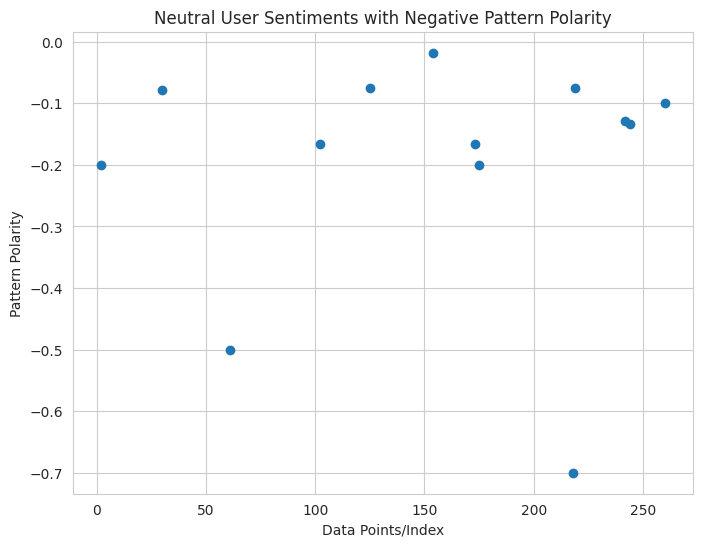

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(Negative_neutral_sentiment.index, Negative_neutral_sentiment['pattern_polarity'])
plt.title('Neutral User Sentiments with Negative Pattern Polarity')
plt.xlabel('Data Points/Index')
plt.ylabel('Pattern Polarity')
plt.show()

In [ ]:
Negative_neutral_sentiment = Negative_neutral_sentiment[['content', 'user_sentiment', 'pattern_polarity']]
Negative_neutral_sentiment.head(10)



,content,user_sentiment,pattern_polarity
2,The chicken ready eat,Neutral,-0.200000
30,sole flat pale,Neutral,-0.078333
61,If write address Ill deliver,Neutral,-0.500000
102,I purchased black pants shoes,Neutral,-0.166667
125,She spent long looking match,Neutral,-0.075000
154,I believe large scales small bodies,Neutral,-0.017857
173,Jon ran bath son wearing black tshirt,Neutral,-0.166667
175,The dog liked guard house postman could make d...,Neutral,-0.200000
218,Complaints NBA referees growing ugly,Neutral,-0.700000
219,Squad helps dog bite victim,Neutral,-0.075000


these data points had neutral user sentiment but were predicted with negative polarity by the model.

In [ ]:
#Neutral user sentiment that were predicted posotive by the model.
positive_neutral_sentiment = df[(df['user_sentiment'] == 'Neutral') & ((df['pattern_polarity'] > 0))]
num_neutral_negative = len(positive_neutral_sentiment)
print("Number of positive sentiments with neutral polarity:", num_neutral_negative)

Number of positive sentiments with neutral polarity: 29


In [ ]:
positive_neutral_sentiment

,equivocal_word,ambiguous_structure,user_sentiment,content_without_stopwords,content,textblob_polarity,textblob_subjectivity,pattern_polarity,pattern_subjectivity
41,False,True,Neutral,Seb got bath ready son wearing blue cape.,Seb got bath ready son wearing blue cape,0.100000,0.300000,0.100000,0.300000
62,True,False,Neutral,What's important object life?,Whats important object life,0.400000,1.000000,0.400000,1.000000
64,True,False,Neutral,The government working experimental compound,The government working experimental compound,0.100000,0.400000,0.100000,0.400000
69,True,False,Neutral,I asked king favorite subjects,I asked king favorite subjects,0.500000,1.000000,0.500000,1.000000
77,True,False,Neutral,She fell near bank,She fell near bank,0.100000,0.400000,0.100000,0.400000
103,False,True,Neutral,"It matter, needs get two new jackets sweaters",It matter needs get two new jackets sweaters,0.136364,0.454545,0.136364,0.454545
111,True,False,Neutral,They people make sure plants well,They people make sure plants well,0.500000,0.888889,0.500000,0.888889
118,True,False,Neutral,Every new drill inspected,Every new drill inspected,0.136364,0.454545,0.136364,0.454545
119,True,False,Neutral,The new drill increased safety lot,The new drill increased safety lot,0.136364,0.454545,0.136364,0.454545
134,False,True,Neutral,The workers started frequently made money,The workers started frequently made money,0.100000,0.300000,0.100000,0.300000


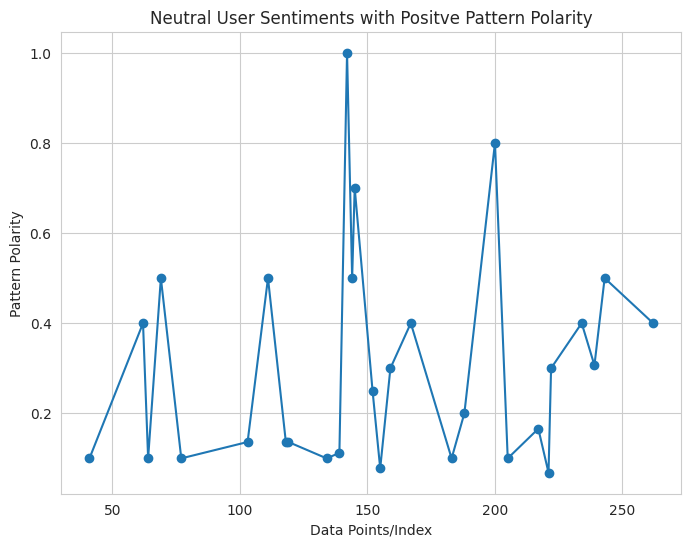

In [ ]:
# Set style
sns.set_style("whitegrid")

# Create line plot
plt.figure(figsize=(8, 6))
plt.plot(positive_neutral_sentiment['pattern_polarity'], marker='o')

# Add title and labels
plt.title('Neutral User Sentiments with Positve Pattern Polarity')
plt.xlabel('Data Points/Index')
plt.ylabel('Pattern Polarity')

# Show plot
plt.show()

The user sentiment for these 25 datapoints in the original dataset was "Neutral", but the model predicted them as "positive" via pattern polarity. It means the model was not able to perform well in predicting sentiment of these data points. (Although pattern polarity for some of them are not 0, but they are actually very close to 0).  

In [ ]:
positive_neutral_sentiment = positive_neutral_sentiment[['content', 'user_sentiment', 'pattern_polarity']]
positive_neutral_sentiment.head(10)

,content,user_sentiment,pattern_polarity
41,Seb got bath ready son wearing blue cape,Neutral,0.100000
62,Whats important object life,Neutral,0.400000
64,The government working experimental compound,Neutral,0.100000
69,I asked king favorite subjects,Neutral,0.500000
77,She fell near bank,Neutral,0.100000
103,It matter needs get two new jackets sweaters,Neutral,0.136364
111,They people make sure plants well,Neutral,0.500000
118,Every new drill inspected,Neutral,0.136364
119,The new drill increased safety lot,Neutral,0.136364
134,The workers started frequently made money,Neutral,0.100000


#Export [NEEDS TO BE UPDATED]

In [ ]:
#Export to Drive
#Used this for reference: https://cyublog.com/articles/python-en/colab-pandas-three-ways-to-save-dataframe-data/
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/NLP/Sentiment_Analysis_Example/sentiment_scores_output.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)

Mounted at /content/drive


FileNotFoundError: ignored